<a href="https://colab.research.google.com/github/joshualewin6/Colab-Notebook/blob/main/Copy_of_Unit6ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 6 Exercises: Is my model good?

#### Over and Under fitting, Model Visualization, and Model/Variable Selection Concepts

These exercises are meant to get you to think about the model and variable selection process, and consider how we determine if a model is "good".

In [15]:
!pip install git+https://github.com/pydata/xarray.git
import xarray as xr
!pip install bambi
import bambi as bmb
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-dq2htd1i
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-dq2htd1i
  Resolved https://github.com/pydata/xarray.git to commit 6bea71572120c0eef2e4bf8d269d32b17a39dc35
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


**Task1**:

Does elpd_loo mean anything if we only have one model?

No, it'll just give a weight of one. There's only one model, so it isn't actually being compared to anything.

**Task2**:

Describe overfitting, in the context of this course

It's when the model is fitting to noise and random variations, can stem from modeling on faulty correlations.

**Task3**:

How do we mitigate overfitting?

We only choose a couple predictors and put them in the model, while paying attention to the DAG and making sure we don't inclde things the predicted affects.

**Task4**:

How do we mitigate underfitting?

Making sure the predictors you do chose have a high elpd_loo, so that your priors don't overpower the data. Also, more than one predictor can eliminate errors and noise that's extreme enough to underfit the data.

**Task5**:

Why would we want more than one predictor in a model?

It prevents underfitting, and for anything you could want to predict, it's more likely than not that it would have multiple things that influence it.

**Task6**:

Can we have too many predictors? How would we know?

Yes, when the data ceases to work on the test data, it's overfitting, so we can tell there's a predictor that shouldn't be there.

**Task7**:

What is variable selection, and how does it work?

For variable selection, create causal DAG to see which variables influence the predicted most. A small group of the variables which directly and indirectly have the strongest influence over the predicted variable should be used in the model.

**Task8**:

Describe the differences and similarities between the following three models: linear regression with two predictors, one of which is a categorical variable:

- adding the variables in the model, as is standard.
- using that categorical variable as a hierarchy upon the other predictor variable.
- adding the variables, plus the categorical variable's interaction with the other variable.

Adding the variables with a constant for the category will yield lines with nearly the same slopes for each category, since adding the category won't affect slopes, thus making each category heavily dependent on the overall data.

A hierarchical model is similar, but this time each category, while still being a little dependent on overall data, is much more reliant on that category's data.

The variable interaction makes the categorical variable directly afffect the predictor, causing the individual plots by category to be nearly independent of inflluence from the rest of the data.

**Task9**:

How do we visualize multiple linear regression models? Can we visualize the entire model, all at once?

You plot all the lines on the same graph to compare them and allow yourself to see the whole model at once.

**Task10**:

Compare the following linear models that all use the basketball data to predict field goal percentage:

- predictors free throw percentage and position (with position as a categorical predictor)
- predictors free throw percentage and position (with position as a hierarchy)
- predictors free throw percentage and position (with position interacting with frew throw percentage)
- predictors free throw percentage, position, 3 point attempts, and interactions between all three predictors
- predictors free throw percentage, position, 3 point attempts, with an interaction between 3 point attempts and postion.

using ```az.compare()``` and ```az.plot_compare()```, or an equivalent method using LOO (elpd_loo).

You may use the following two code blocks to load and clean the data.

In [16]:
#have to drop incomplete rows, so that bambi will run
bb = pd.read_csv(
    'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv').dropna()
#only look at players who played more than 600 minutes
#which is 20 min per game, for 30 games
bb = bb.query('MP > 600')
#remove players who never missed a free throw
bb = bb.query('`FT%` != 1.0')
#filter out the combo positions. This will make it easier to read the graphs
bb = bb.query("Pos in ['C','PF','SF','SG','PG']")
#gets rid of the annoying '%' sign
bb.rename(columns={"FT%":"FTp","FG%":"FGp"}, inplace=True)
bb

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FGp,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
5,Grayson Allen,SG,28,PHO,75,74,2513,340,682,0.499,...,48,247,295,227,69,45,95,157,1014,allengr01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,Jalen Wilson,PF,23,BRK,43,3,664,76,179,0.425,...,47,84,131,45,11,4,19,48,214,wilsoja03
563,James Wiseman,C,22,DET,63,6,1091,187,305,0.613,...,110,226,336,54,12,39,66,141,446,wisemja01
565,Christian Wood,PF,28,LAL,50,1,872,123,264,0.466,...,39,215,254,49,16,33,50,72,347,woodch01
566,Delon Wright,PG,31,TOT,47,1,742,74,188,0.394,...,19,67,86,119,54,11,14,32,210,wrighde01


Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FTp', ylabel='FGp'>], dtype=object))

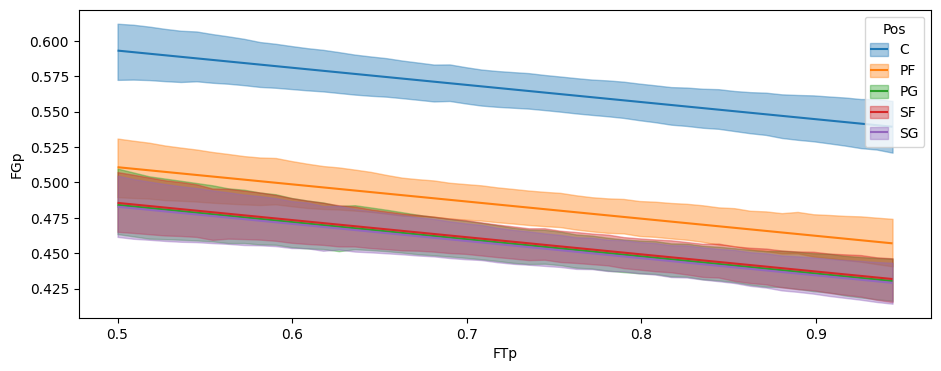

In [17]:
model_bb = bmb.Model("FGp ~ FTp+Pos", data=bb)
idata_bb = model_bb.fit(idata_kwargs={'log_likelihood': True})
bmb.interpret.plot_predictions(model_bb,
                               idata_bb,
                                ["FTp",  "Pos"], fig_kwargs={"figsize":(11, 4)})

Output()

Output()

ERROR:pymc.stats.convergence:There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FTp', ylabel='FGp'>], dtype=object))

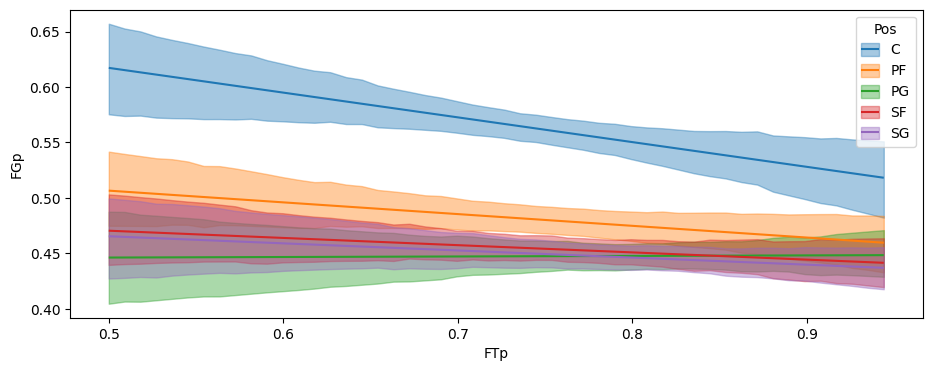

In [18]:
model_bb_h = bmb.Model("FGp ~ (FTp|Pos)", data=bb)
idata_bb_h = model_bb_h.fit(idata_kwargs={'log_likelihood': True})
bmb.interpret.plot_predictions(model_bb_h,
                               idata_bb_h,
                                ["FTp",  "Pos"], fig_kwargs={"figsize":(11, 4)})

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FTp', ylabel='FGp'>], dtype=object))

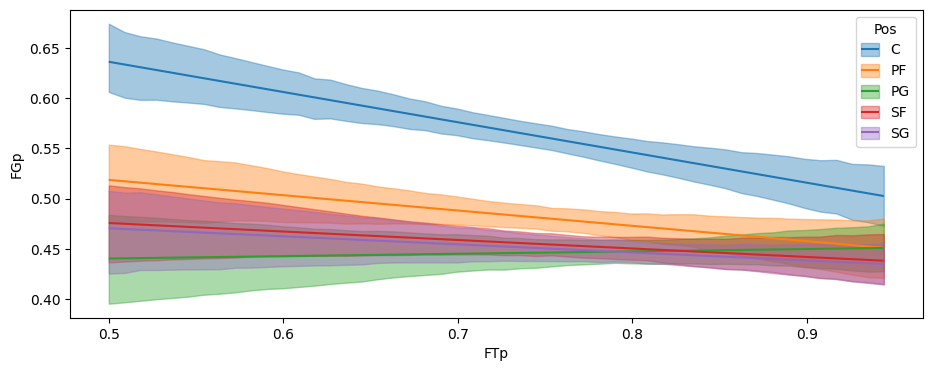

In [19]:
model_bb_i = bmb.Model("FGp ~ FTp + Pos + FTp:Pos)", data=bb)
idata_bb_i = model_bb_i.fit(idata_kwargs={'log_likelihood': True})
bmb.interpret.plot_predictions(model_bb_i,
                               idata_bb_i,
                                ["FTp",  "Pos"], fig_kwargs={"figsize":(11, 4)})

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x1100 with 1 Axes>,
 array([<Axes: xlabel='FTp', ylabel='FGp'>], dtype=object))

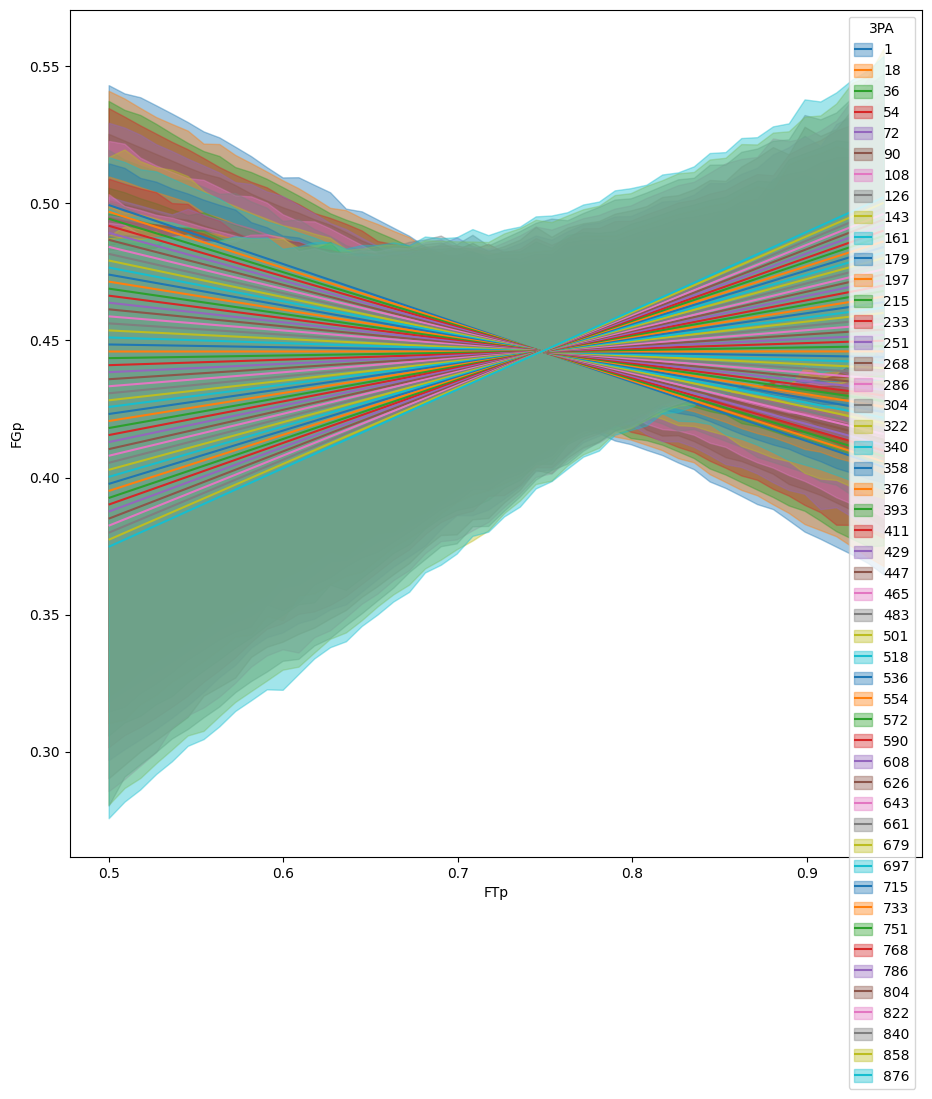

In [20]:
model_bb_iii = bmb.Model("FGp ~ FTp + Pos + `3PA` + FTp:Pos + FTp:`3PA` + Pos:`3PA`)", data=bb)
idata_bb_iii = model_bb_iii.fit(idata_kwargs={'log_likelihood': True})
bmb.interpret.plot_predictions(model_bb_iii,
                               idata_bb_iii,
                                ["FTp",  "3PA"], fig_kwargs={"figsize":(11, 11)})

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FTp', ylabel='FGp'>], dtype=object))

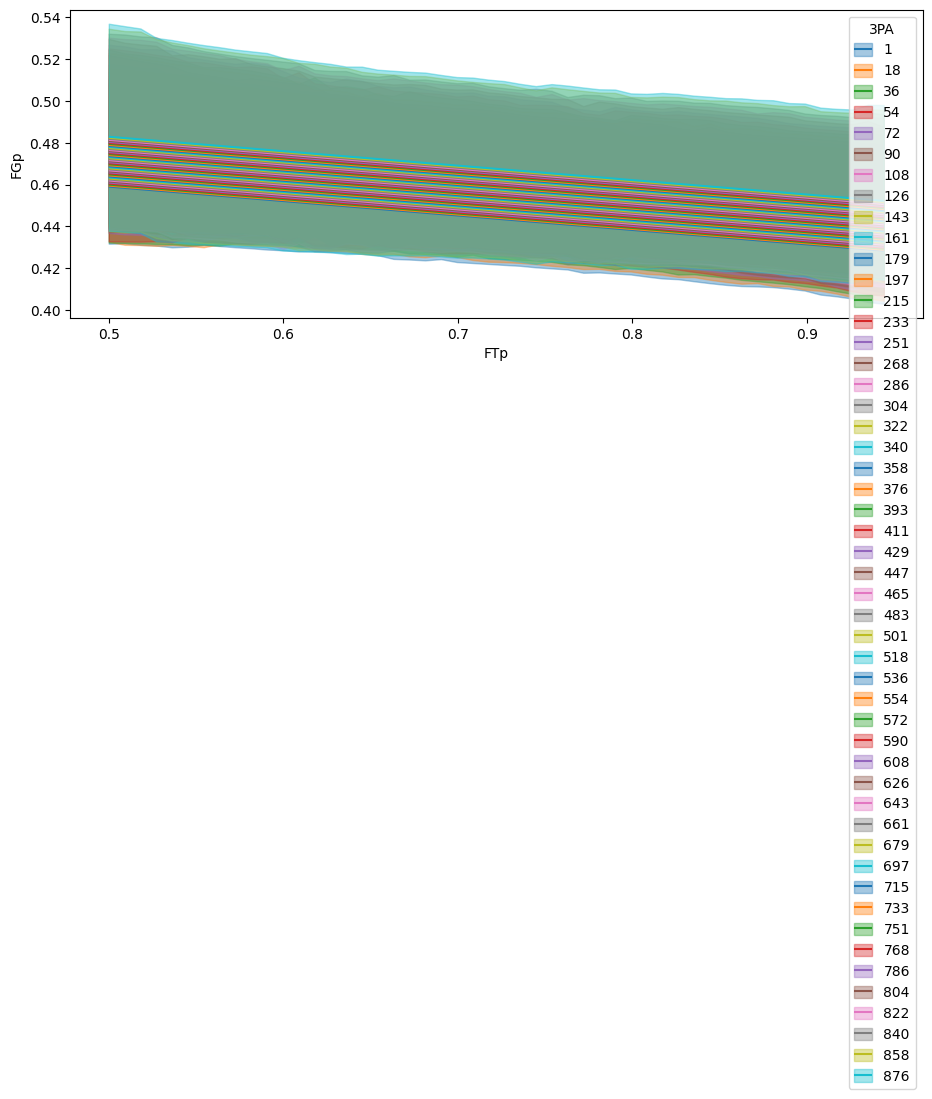

In [21]:
model_bb_ooi = bmb.Model("FGp ~ FTp + Pos + `3PA` + Pos:`3PA`)", data=bb)
idata_bb_ooi = model_bb_ooi.fit(idata_kwargs={'log_likelihood': True})
bmb.interpret.plot_predictions(model_bb_ooi,
                               idata_bb_ooi,
                                ["FTp",  "3PA"], fig_kwargs={"figsize":(11, 4)})

In [22]:
cmp_bb = az.compare( {"standard":idata_bb,"hierarchy":idata_bb_h, "interact_one":idata_bb_i, "interact_all":idata_bb_iii, "interact_pos_tpa":idata_bb_ooi} )
cmp_bb

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
interact_pos_tpa,0,529.707785,12.839454,0.000000,5.567066e-01,15.825078,0.000000,False,log
interact_all,1,529.152163,18.926468,0.555623,4.432934e-01,14.882885,3.780043,False,log
interact_one,2,509.379095,13.837702,20.328690,6.095444e-16,16.789015,7.712964,False,log
hierarchy,3,507.994130,14.066930,21.713655,0.000000e+00,17.083059,7.140563,False,log
standard,4,507.305250,8.352312,22.402535,0.000000e+00,16.094461,6.811844,False,log


**Task11**:

Which model is "better" according to this metric?

Ultimately, the one that includes three point attempts and only interacts 3PA and Pos is the best one according to the elpd_loo numbers, with the one that has all three interactions coming in as a close second.


Why do you think that is?

The most accurate causal DAG would have position strongly impacting three point attemps, since certain positions have it as their job to shoot threes, while other necessarily need to stay in the paint to be good. Three point attempts and position would also lightly interact with free throw percentage, since FTp is dependent on shooting skill. Those two interactions are weak enough though that the single interaction is a stronger graph.